In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from ipywidgets import interact, SelectionSlider, Layout
from scipy import signal


import sys
sys.path.append('../code/')
from utils import linear_scale_forward, linear_scale_array
device = 'cpu'

In [2]:
labels = ['Amp 1', 'Amp 2', 'Pulse Diff']

dpl_data = np.load('../data/rc_circuit/grid_sweep/dpl_sim_grid.npy')
theta_samples = np.load('../data/rc_circuit/grid_sweep/theta_sim_grid.npy')


n_sims, n_params = theta_samples.shape
param_values = [np.unique(theta_samples[:, idx]) for idx in range(n_params)]
lookup_dict = {tuple(theta_samples[idx,:]): idx for idx in range(n_sims)}

slider_dict = {f'p{idx}': SelectionSlider(options=param_values[idx],
               description=labels[idx], style={'description_width': '150px'},
               layout=Layout(width='500px')) for 
               idx in range(len(param_values))}


In [3]:
theta_ranges = [('amp1', (0, 1), linear_scale_forward),
                ('amp2', (-1, 0), linear_scale_forward), 
                ('pulse_diff', (-20, 20), linear_scale_forward)]

interactive(children=(SelectionSlider(description='Amp 1', layout=Layout(width='500px'), options=(1e-10, 0.052…

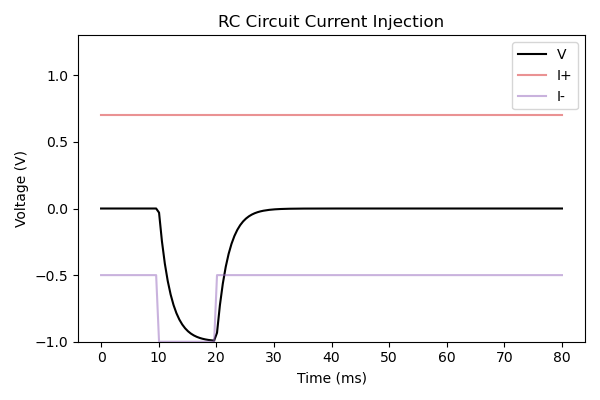

In [4]:
%matplotlib widget

fig, axes = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)

tstop = 80
dt = 0.5
t_vec = np.linspace(0, tstop, np.round(tstop/dt).astype(int))
pulse_flat = np.zeros(t_vec.shape[0])

i1_start = 30
pulse_width = 10

@interact(**slider_dict)
def plot_dipole(p0, p1, p2):
    axes.clear()

    lookup_values = (p0, p1, p2)
    cond_idx = lookup_dict[lookup_values]

    real_param_vals = list()
    for p_idx in range(3):
        _, bounds, rescale_func = theta_ranges[p_idx]
        real_param_vals.append(rescale_func(lookup_values[p_idx], bounds))

    amp1, amp2, pulse_diff = real_param_vals
    pulse1, pulse2 = pulse_flat.copy(), pulse_flat.copy()
    mask1 = np.logical_and(t_vec > i1_start, t_vec < i1_start + pulse_width)
    pulse1[mask1] = np.repeat(amp1, sum(mask1))

    i2_start = i1_start + pulse_diff
    mask2 = np.logical_and(t_vec > i2_start, t_vec < i2_start + pulse_width)
    pulse2[mask2] = np.repeat(amp2, sum(mask2))

    pulse1 = pulse1 /2 + 0.7
    pulse2 = pulse2 /2 - 0.5

    axes.plot(t_vec, dpl_data[cond_idx,:], color='k', label='V')
    axes.plot(t_vec, pulse1, color='C3', alpha=0.5, label='I+')
    axes.plot(t_vec, pulse2, color='C4', alpha=0.5, label='I-')
    axes.legend(loc='upper right')

    axes.set_title('RC Circuit Current Injection')
    axes.set_xlabel('Time (ms)')
    axes.set_ylabel('Voltage (V)')
    axes.set_ylim([-1, 1.3])

interactive(children=(SelectionSlider(description='Amp 1', index=9, layout=Layout(width='500px'), options=(1e-…

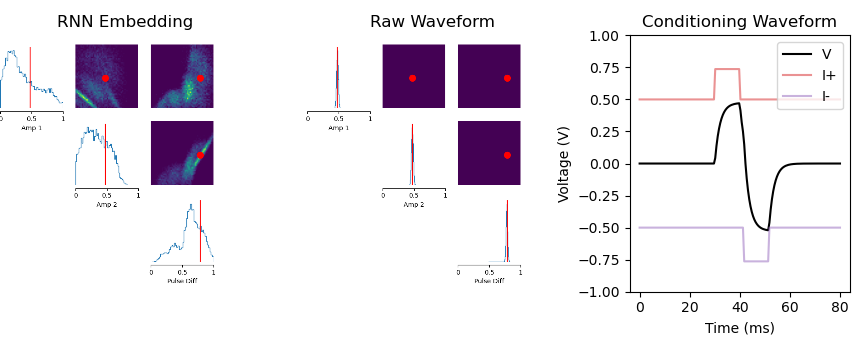

In [17]:
%matplotlib widget

input_type_list = ['params3_sims100000_psd_noise']
title_list = ['PSD']
#input_type_list = ['params3_sims100000_raw_waveform_noise']
num_plots = len(input_type_list) + 1

num_plots = 3
fig, axes = plt.subplots(1, num_plots, figsize=(2.55 * num_plots+1 ,3.5), tight_layout=True)

tstop = 80
dt = 0.5
t_vec = np.linspace(0, tstop, np.round(tstop/dt).astype(int))
pulse_flat = np.zeros(t_vec.shape[0])

i1_start = 30
pulse_width = 10

@interact(**slider_dict)
def plot_dipole(p0, p1, p2):
    for idx in range(num_plots):
        axes[idx].clear()

    lookup_values = (p0, p1, p2)
    cond_idx = lookup_dict[lookup_values]

    real_param_vals = list()
    for p_idx in range(3):
        _, bounds, rescale_func = theta_ranges[p_idx]
        real_param_vals.append(rescale_func(lookup_values[p_idx], bounds))

    amp1, amp2, pulse_diff = real_param_vals
    pulse1, pulse2 = pulse_flat.copy(), pulse_flat.copy()
    mask1 = np.logical_and(t_vec > i1_start, t_vec < i1_start + pulse_width)
    pulse1[mask1] = np.repeat(amp1, sum(mask1))

    i2_start = i1_start + pulse_diff
    mask2 = np.logical_and(t_vec > i2_start, t_vec < i2_start + pulse_width)
    pulse2[mask2] = np.repeat(amp2, sum(mask2))

    pulse1 = pulse1 /2 + 0.5
    pulse2 = pulse2 /2 - 0.5

    axes[num_plots-1].plot(t_vec, dpl_data[cond_idx,:], color='k', label='V')
    axes[num_plots-1].plot(t_vec, pulse1, color='C3', alpha=0.5, label='I+')
    axes[num_plots-1].plot(t_vec, pulse2, color='C4', alpha=0.5, label='I-')
    axes[num_plots-1].legend(loc='upper right')



    axes[num_plots-1].set_title('Conditioning Waveform')
    axes[num_plots-1].set_xlabel('Time (ms)')
    axes[num_plots-1].set_ylabel('Voltage (V)')
    axes[num_plots-1].set_ylim([-1, 1])

    for idx, input_type in enumerate(input_type_list):
        #arr_img = plt.imread(f'../data/rc_circuit/conditional_plots/{input_type}/params3_sims100000_{input_type}_noise_conditional_{cond_idx}.png')
        arr_img = plt.imread(f'../data/rc_circuit/marginal_plots/{input_type}/{input_type}_marginals_{cond_idx}.png')
        im = OffsetImage(arr_img, zoom=0.33)
        ab = AnnotationBbox(im, (1, 0), xycoords='data', box_alignment=(0.98,0), frameon=False)
        axes[idx].add_artist(ab)
        axes[idx].axis('off')
        axes[idx].set_title(title_list[idx])
        #axes[idx].set_title(f'{cond_idx}')


